In [1]:
import os
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


In [2]:
DATA_PATH = "/kaggle/input/fall-23-intro-to-vision-dataset/Dataset/detection/"

In [3]:
class_ids = [
    'jelly',
    'fish',
    'shark',
    'tuna',
]
class_mapping = {i: class_ids[i] for i in range(len(class_ids))}
class_mapping_r = {class_ids[i]: i for i in range(len(class_ids))}

In [4]:
def load_folder(path):
    image_paths, anns_paths, labels = [], [], []

    for root, dirs, files in os.walk(path):
        if len(files) == 0:
            continue

        label = os.path.basename(root)
        for file in files:
            name, ext = os.path.splitext(file)
            if ext == '.jpg':
                img_path = os.path.join(root, name)
                image_paths.append(img_path + '.jpg')
                anns_paths.append(img_path + '.txt')
                labels.append(label.lower())
    return image_paths, anns_paths, labels

In [5]:
def parse_annotation(anns_path):
    boxes = []
    with open(anns_path, 'r') as f:
        for line in f.readlines():
            boxes.append(
                [int(num) for num in line.split(',')[2:]]
            )
    return boxes

def load_dataset(path):
    image_paths, anns_paths, labels = load_folder(path)
    
    bbox, classes = [], []
    for i in range(len(anns_paths)):
        boxes = parse_annotation(anns_paths[i])
        bbox.append(boxes)
        classes.append([class_mapping_r[labels[i]]] * len(boxes))
    
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
    

    return tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [6]:
train_data = load_dataset(os.path.join(DATA_PATH, 'train'))
val_data = load_dataset(os.path.join(DATA_PATH, 'val'))

In [7]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [8]:
SIZE = (640, 640)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=SIZE, scale_factor=(1.0, 1.0), bounding_box_format="xyxy"
        ),
    ]
)

In [9]:
BATCH_SIZE = 8

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
resizing = keras_cv.layers.JitteredResize(
    target_size=SIZE,
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

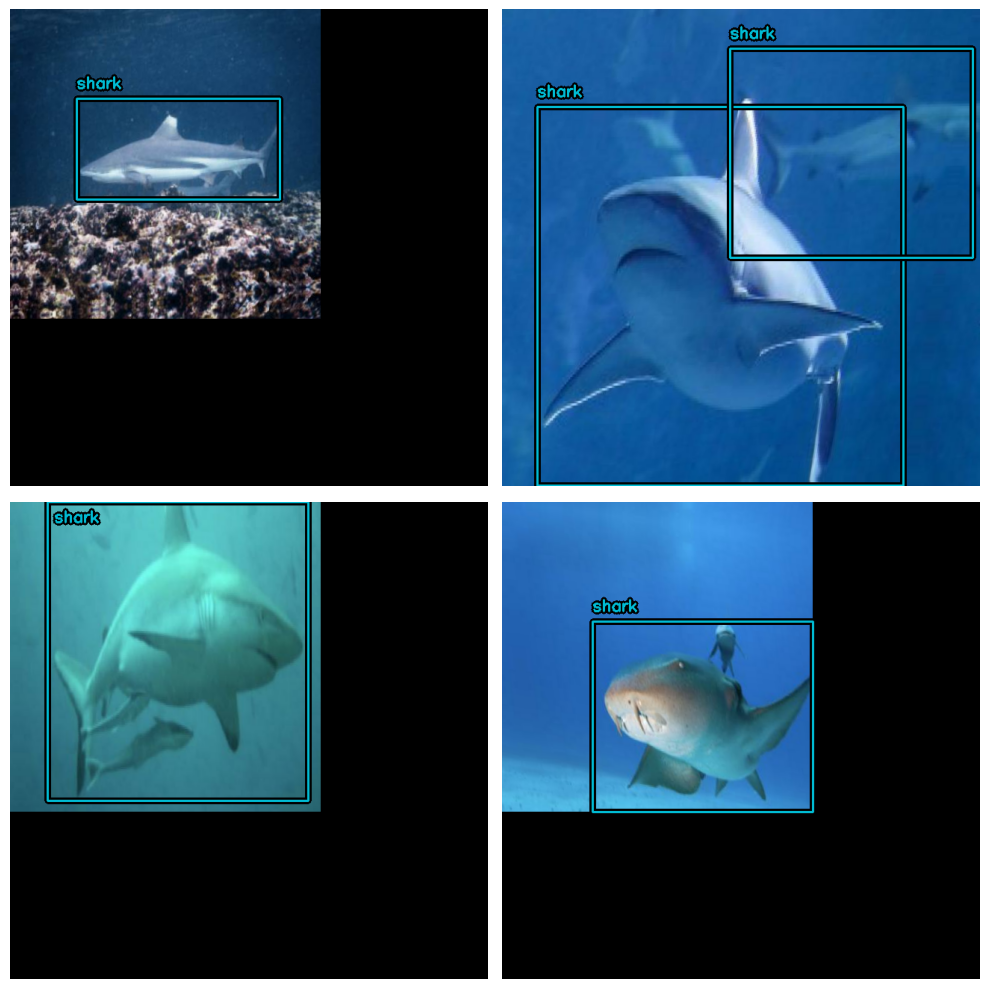

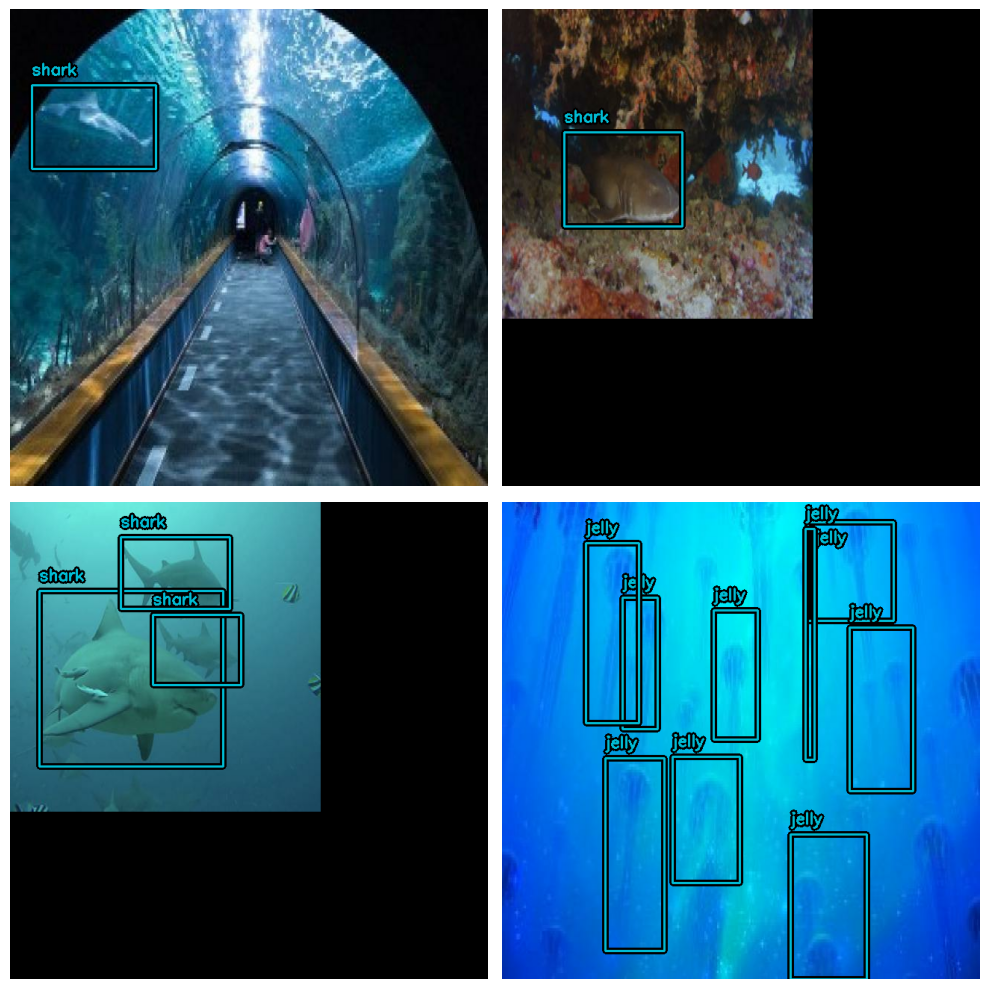

In [11]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [12]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",  # We will use yolov8 small backbone with coco weights
    load_weights=False
)

Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_l_backbone_coco/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_l_backbone_coco/1' to your Kaggle notebook...


In [14]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [15]:
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.01,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [16]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
)

Epoch 1/60
87/87 [==============================] - 158s 675ms/step - loss: 54.6790 - box_loss: 2.9163 - class_loss: 51.7627 - val_loss: 4.1244 - val_box_loss: 2.7995 - val_class_loss: 1.3249
Epoch 2/60
87/87 [==============================] - 56s 633ms/step - loss: 4.0079 - box_loss: 2.8977 - class_loss: 1.1102 - val_loss: 3.8441 - val_box_loss: 2.7809 - val_class_loss: 1.0632
Epoch 3/60
87/87 [==============================] - 56s 633ms/step - loss: 3.9599 - box_loss: 2.8922 - class_loss: 1.0677 - val_loss: 3.8267 - val_box_loss: 2.7490 - val_class_loss: 1.0776
Epoch 4/60
87/87 [==============================] - 56s 633ms/step - loss: 3.8982 - box_loss: 2.8464 - class_loss: 1.0517 - val_loss: 3.9833 - val_box_loss: 2.8818 - val_class_loss: 1.1016
Epoch 5/60
87/87 [==============================] - 58s 649ms/step - loss: 3.8187 - box_loss: 2.7900 - class_loss: 1.0287 - val_loss: 3.8441 - val_box_loss: 2.7708 - val_class_loss: 1.0734
Epoch 6/60
87/87 [==============================] - 

1/1 [==============================] - 5s 5s/step


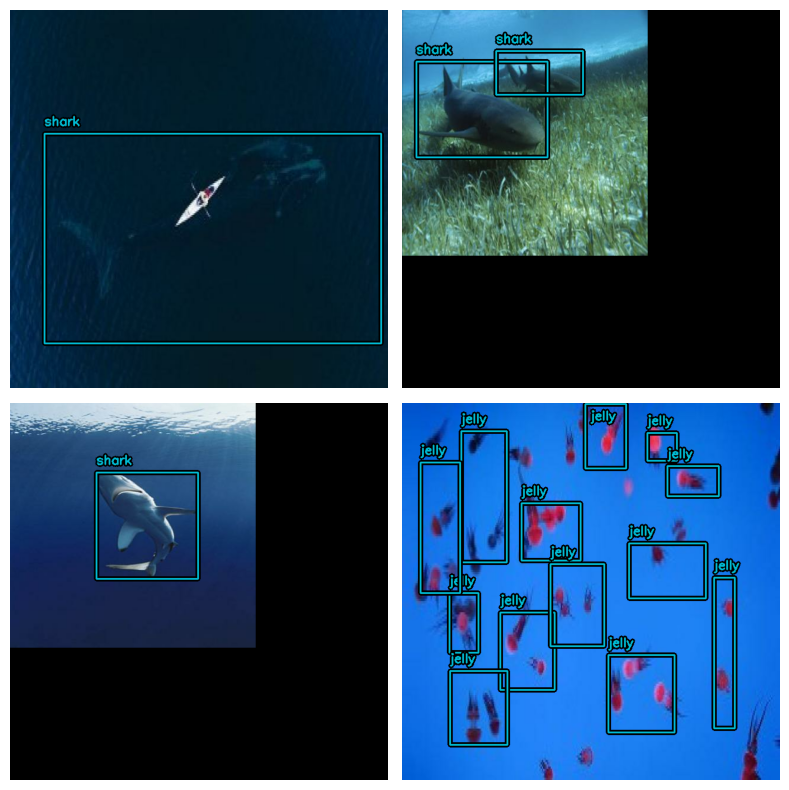

{'boxes': <tf.RaggedTensor [[], [], [], [], [], [[47.35311, 78.28268, 400.27533, 368.3924]], [], []]>, 'confidence': <tf.RaggedTensor [[], [], [], [], [], [0.2022567], [], []]>, 'classes': <tf.RaggedTensor [[], [], [], [], [], [1.0], [], []]>, 'num_detections': array([0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)}


In [17]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )
    print(y_pred)


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

In [18]:

yolo.save('/kaggle/working/my_model(my).h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
